## <center><b> FastSAM Enabled M&M Detection and Counting</center>
### <center><b>AISE 3350A FW24: Cyber-Physical Systems Theory</b></center>

<center>Group # 1:</center>
<center>Gui Moraes Brant De Almeida: 251301839</center>
<center>Joel Friesen Waldner: 251303569</center>
<center>Addy Virk: 251311740</center>
<center>Cristian Forero Duenas:250998245</center>
<br>
<center>Due December 20, 2024</center>

In [1]:
import os
import json
import numpy as np
import cv2
from ultralytics import FastSAM
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk, filedialog

In [3]:
# Load the pre-trained FastSAM model
model = FastSAM("FastSAM-x.pt")

# Define HSV color ranges for different M&M colors
colour_ranges = {
    'red': {
        'lower1': np.array([0, 100, 100]),
        'upper1': np.array([5, 255, 255]),
        'lower2': np.array([165, 100, 100]),
        'upper2': np.array([180, 255, 255])
    },
    'orange': {
        'lower': np.array([6, 100, 100]),
        'upper': np.array([15, 255, 255])
    },
    'blue': {
        'lower': np.array([81, 100, 100]),
        'upper': np.array([140, 255, 255])
    },
    'green': {
        'lower': np.array([40, 100, 100]),
        'upper': np.array([80, 255, 255])
    },
    'yellow': {
        'lower': np.array([15, 100, 100]),
        'upper': np.array([35, 255, 255])
    },
    'brown': {
        'lower': np.array([0, 20, 0]),
        'upper': np.array([30, 255, 100])
    }
}

# Variable to store the path of the currently loaded image
current_image_path = None

def convert_xyxy_to_xywh(bboxes):

    """
    Converts bounding box coordinates from (x1, y1, x2, y2) to (x, y, w, h).

    Parameters:
    - bboxes: List of bounding box coordinates in the form [x1, y1, x2, y2]

    Returns:
    - List of bounding boxes in the form [x, y, w, h]
    """

    converted_bboxes = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox.xyxy[0]
        x = int(x1)
        y = int(y1)
        w = int(x2 - x1)
        h = int(y2 - y1)
        converted_bboxes.append([x, y, w, h])
    return converted_bboxes

def exclude_contained_bboxes(bboxes, img):

    """
    Excludes bounding boxes that are completely contained within other bounding boxes
    and those that take up more than half the image.

    Parameters:
    - bboxes: List of bounding box coordinates in the form [x, y, w, h]
    - img: The original image as a NumPy array.

    Returns:
    - A new list of bounding boxes excluding those completely contained within others
      and those that take up more than half the image.
    """

    def is_contained(box1, box2):

        """
        Check if box1 is completely contained within box2.
        """

        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        return x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2)

    # Image dimensions
    img_height, img_width = img.shape[:2]
    img_area = img_width * img_height

    # Filter out bounding boxes that take up more than half the image
    # This is necessary because sometimes the entire image is placed inside a box
    filtered_bboxes = [box for box in bboxes if (box[2] * box[3]) <= (img_area / 2)]

    # List to store the final filtered bounding boxes
    final_bboxes = []

    for i, box1 in enumerate(filtered_bboxes):
        contained = False
        for j, box2 in enumerate(filtered_bboxes):
            if i != j and is_contained(box1, box2):
                contained = True
                break
        if not contained:
            final_bboxes.append(box1)

    return final_bboxes

def find_dominate_colour(image, bbox):

    """
    Finds the dominate colour inside the bounding box.

    Parameters:
    - image: The input image.
    - bbox: The bounding box coordinates in the form [x, y, w, h].

    Returns:
    - The modal colour inside the bounding box as a tuple (B, G, R).
    """

    x, y, w, h = bbox

    # Extract the region of interest (ROI) from the image
    roi = image[y:y + h, x:x + w]

    img = Image.fromarray(roi)
    img.thumbnail((100, 100))

    # Reduce colors (uses k-means internally)
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=16)

    # Find the color that occurs most often
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    palette_index = color_counts[0][1]
    dominant_colour = palette[palette_index * 3:palette_index * 3 + 3]
    return dominant_colour

def convert_rgb_to_hsv(color_rgb):

    """
    Converts an RGB colour to HSV.

    Parameters:
    - colour_rgb: Tuple representing the RGB color (R, G, B).

    Returns:
    - The HSV colour as a tuple (H, S, V).
    """

    colour_bgr = np.uint8([[list(color_rgb)]])
    hsv_color = cv2.cvtColor(colour_bgr, cv2.COLOR_BGR2HSV)[0][0]
    return hsv_color

def is_colour_in_range(hsv_colour, lower, upper):

    """
    Checks if the HSV colour is within the specified range.

    Parameters:
    - hsv_colour: The HSV color to check.
    - lower: The lower bound of the HSV range.
    - upper: The upper bound of the HSV range.

    Returns:
    - True if the colour is in the range, False otherwise.
    """

    return np.all(hsv_colour >= lower) and np.all(hsv_colour <= upper)

def count_bounding_boxes_by_colour(image, bboxes, colour_ranges):

    """
    Counts the number of bounding boxes by their dominant colour defined by colour ranges.

    Parameters:
    - image: The input image.
    - bboxes: List of bounding box coordinates in the form [x, y, w, h].
    - colour_ranges: Dictionary of colour ranges in HSV.

    Returns:
    - Dictionary with counts of bounding boxes for each colour.
    """

    colour_counts = {colour: 0 for colour in colour_ranges}
    colour_counts['unknown'] = 0

    for bbox in bboxes:
        unknown = True
        dominant_colour = find_dominate_colour(image, bbox)
        hsv_colour = convert_rgb_to_hsv(dominant_colour)

        for colour, ranges in colour_ranges.items():

            if 'lower1' in ranges and 'upper1' in ranges:

                if is_colour_in_range(hsv_colour, ranges['lower1'], ranges['upper1']) or \
                        is_colour_in_range(hsv_colour, ranges['lower2'], ranges['upper2']):
                    colour_counts[colour] += 1
                    unknown = False
                    break

            elif is_colour_in_range(hsv_colour, ranges['lower'], ranges['upper']):
                colour_counts[colour] += 1
                unknown = False
                break

        if unknown:
            colour_counts['unknown'] += 1

    return colour_counts

def resize_image(image, target_size=(600, 600)):

    """Resize and pad the image to fit within the target size while maintaining the aspect ratio."""

    h, w = image.shape[:2]
    target_w, target_h = target_size
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    padded_image = np.full((target_h, target_w, 3), 255, dtype=np.uint8)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image
    return padded_image

def load_image():

    """Opens a file dialog for the user to select an image."""

    global current_image_path
    file_path = filedialog.askopenfilename(
        filetypes=[("Image Files", "*.jpg;*.jpeg;*.png;*.webp")]
    )
    if file_path:
        current_image_path = file_path
        display_image(file_path)

def save_results(results):

    """Saves the results as a JSON file."""

    save_path = filedialog.asksaveasfilename(
        defaultextension=".json",
        filetypes=[("JSON Files", "*.json")],
    )
    if save_path:
        with open(save_path, "w") as json_file:
            json.dump(results, json_file, indent=4)

def clear_display():

    """Clears the image canvas and results box."""

    canvas_image.delete("all")
    results_text.config(state=tk.NORMAL)
    results_text.delete(1.0, tk.END)
    results_text.config(state=tk.DISABLED)

def run_analysis():

    """Processes the image and analyzes bounding boxes."""

    global current_image_path
    if not current_image_path:
        return
    original_image = cv2.imread(current_image_path)
    all_results = model(source=current_image_path, show=False)
    raw_bboxes = all_results[0].boxes
    bboxes_xywh = convert_xyxy_to_xywh(raw_bboxes)
    filtered_bboxes = exclude_contained_bboxes(bboxes_xywh, original_image)
    dominant_colours = [find_dominate_colour(original_image, bbox) for bbox in filtered_bboxes]
    colour_counts = count_bounding_boxes_by_colour(original_image, filtered_bboxes, colour_ranges)

    # Draw bounding boxes
    image_with_boxes = original_image.copy()
    for bbox, colour in zip(filtered_bboxes, dominant_colours):
        x, y, w, h = bbox
        colour_bgr = (int(colour[0]), int(colour[1]), int(colour[2]))
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), colour_bgr, 2)

    # Display image with bounding boxes
    image_with_boxes = resize_image(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    img_tk = ImageTk.PhotoImage(Image.fromarray(image_with_boxes))
    canvas_image.create_image(0, 0, anchor=tk.NW, image=img_tk)
    canvas_image.image = img_tk

    # Update results in the text box
    results_text.config(state=tk.NORMAL)
    results_text.delete(1.0, tk.END)
    results_text.insert(tk.END, "Analysis Results:\n")
    results_text.insert(tk.END, f"Total M&Ms Detected: {sum(colour_counts.values())}\n")
    for colour, count in colour_counts.items():
        results_text.insert(tk.END, f"{colour.capitalize()}: {count}\n")
    results_text.config(state=tk.DISABLED)

    # Save results when Save Results button is clicked
    save_button.config(command=lambda: save_results(colour_counts))

def display_image(image_path):
    """Displays the loaded image on the canvas."""
    original_image = cv2.imread(image_path)
    resized_image = resize_image(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    img_tk = ImageTk.PhotoImage(Image.fromarray(resized_image))
    canvas_image.create_image(0, 0, anchor=tk.NW, image=img_tk)
    canvas_image.image = img_tk

# GUI Setup
root = tk.Tk()
root.title("M&M Counter System")
root.geometry("1000x625")

# Control Panel
control_frame = tk.Frame(root, padx=10, pady=10)
control_frame.grid(row=0, column=0, sticky="nw")

# File Operations
file_frame = tk.LabelFrame(control_frame, text="File Operations")
file_frame.pack(fill="x", pady=5)
tk.Button(file_frame, text="Load Image", command=load_image).pack(side="left", padx=5, pady=5)
save_button = tk.Button(file_frame, text="Save Results")
save_button.pack(side="left", padx=5, pady=5)

# Processing Controls
process_frame = tk.LabelFrame(control_frame, text="Processing")
process_frame.pack(fill="x", pady=5)
tk.Button(process_frame, text="Process Image", command=run_analysis).pack(side="left", padx=5, pady=5)
tk.Button(process_frame, text="Clear", command=clear_display).pack(side="left", padx=5, pady=5)

# Results Display
results_frame = tk.LabelFrame(control_frame, text="Results")
results_frame.pack(fill="both", expand=True, pady=5)
results_text = tk.Text(results_frame, width=40, height=15, state=tk.DISABLED)
results_text.pack(padx=5, pady=5)

# Image Display
image_frame = tk.Frame(root, padx=10, pady=10)
image_frame.grid(row=0, column=1, sticky="nsew")
canvas_image = tk.Canvas(image_frame, width=600, height=600)
canvas_image.pack()

# Run the GUI
root.mainloop()



image 1/1 C:\Users\mkcli\OneDrive\Desktop\CPSImages\MM4.jpg: 1024x1024 183 objects, 2075.3ms
Speed: 6.5ms preprocess, 2075.3ms inference, 271.0ms postprocess per image at shape (1, 3, 1024, 1024)


##SIMPLE IMAGE ANALYSIS

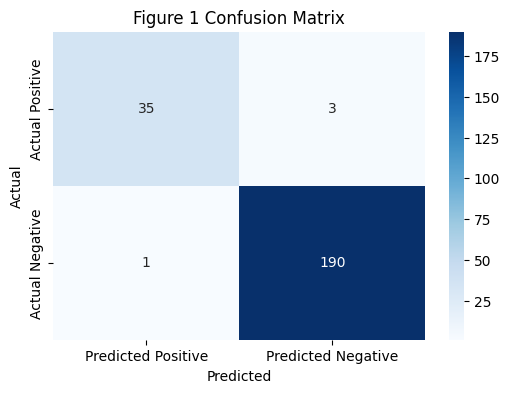

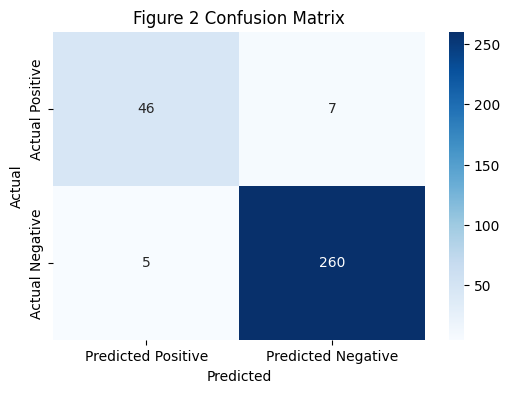

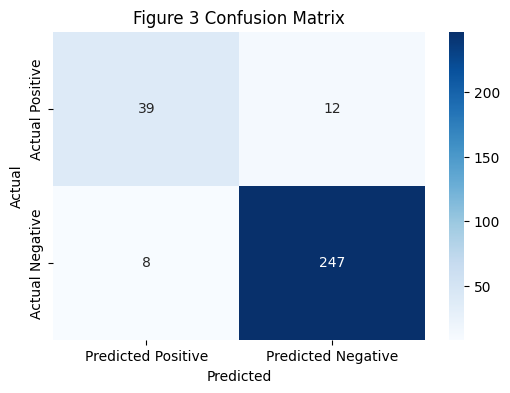

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated data for all figures (from Table 6)
table_6_data = [
    {"Figure": "1", "Total TP": 35, "Total FP": 1, "Total TN": 190, "Total FN": 3},
    {"Figure": "2", "Total TP": 46, "Total FP": 5, "Total TN": 260, "Total FN": 7},
    {"Figure": "3", "Total TP": 39, "Total FP": 8, "Total TN": 247, "Total FN": 12},
]

# Convert the table data into a pandas DataFrame for easier processing
df = pd.DataFrame(table_6_data)

# Visualize and save confusion matrix for each figure
for _, row in df.iterrows():
    figure = f"Figure {row['Figure']}"
    tp = row["Total TP"]
    fp = row["Total FP"]
    tn = row["Total TN"]
    fn = row["Total FN"]

    # Complete confusion matrix
    matrix = [[tp, fn], [fp, tn]]

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Positive", "Predicted Negative"],
        yticklabels=["Actual Positive", "Actual Negative"],
    )
    plt.title(f"{figure} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the plot as an image
    filename = f"{figure.replace(' ', '_')}_Confusion_Matrix.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


In [8]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Updated data for all figures (from Table 6)
table_6_data = [
    {"Figure": "1", "TP": 35, "FP": 1, "TN": 190, "FN": 3},
    {"Figure": "2", "TP": 46, "FP": 5, "TN": 260, "FN": 7},
    {"Figure": "3", "TP": 39, "FP": 8, "TN": 247, "FN": 12},
]

# Results list to store calculated metrics
results = []

# Calculate metrics for each figure
for row in table_6_data:
    figure = f"Figure {row['Figure']}"
    tp = row["TP"]
    fp = row["FP"]
    tn = row["TN"]
    fn = row["FN"]

    # Metrics calculations
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    # Simplified ROC-AUC calculation
    y_true = [1] * tp + [0] * fn + [1] * fp + [0] * tn  # Actual labels
    y_scores = [1] * (tp + fp) + [0] * (tn + fn)  # Predicted scores
    roc_auc = roc_auc_score(y_true, y_scores)

    # Append results
    results.append({
        "Figure": figure,
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-Score": round(f1_score, 2),
        "Accuracy": round(accuracy, 2),
        "ROC-AUC": round(roc_auc, 2),
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Display the updated results
print(results_df)


     Figure  Precision  Recall  F1-Score  Accuracy  ROC-AUC
0  Figure 1       0.97    0.92      0.95      0.98     0.98
1  Figure 2       0.90    0.87      0.88      0.96     0.94
2  Figure 3       0.83    0.76      0.80      0.93     0.90


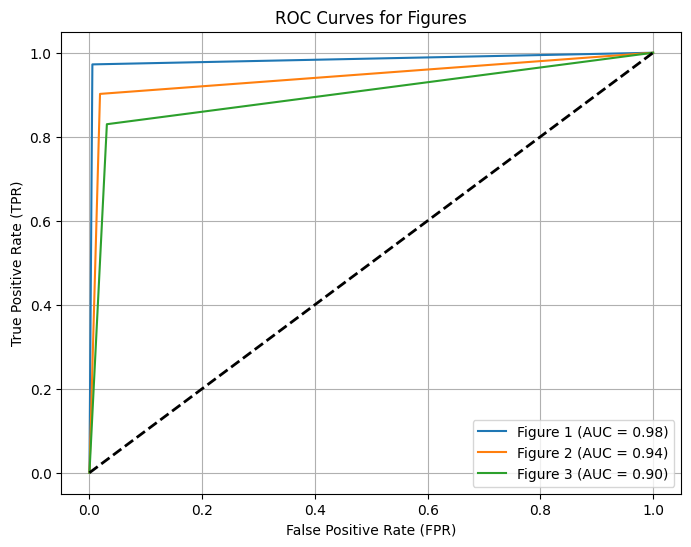

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Updated data for all figures (from Table 6)
table_6_data = [
    {"Figure": "1", "Total TP": 35, "Total FP": 1, "Total TN": 190, "Total FN": 3},
    {"Figure": "2", "Total TP": 46, "Total FP": 5, "Total TN": 260, "Total FN": 7},
    {"Figure": "3", "Total TP": 39, "Total FP": 8, "Total TN": 247, "Total FN": 12},
]

# Generate ROC curve for each figure using simulated data
plt.figure(figsize=(8, 6))
for row in table_6_data:
    figure = f"Figure {row['Figure']}"
    tp = row["Total TP"]
    fp = row["Total FP"]
    tn = row["Total TN"]
    fn = row["Total FN"]

    # Simulate true labels and predicted scores
    y_true = [1] * tp + [0] * fn + [1] * fp + [0] * tn
    y_scores = [1] * (tp + fp) + [0] * (tn + fn)

    # Calculate TPR, FPR, and AUC using roc_curve and roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot ROC curve
    plt.plot(
        fpr, tpr, label=f"{figure} (AUC = {roc_auc:.2f})"
    )

# Plot formatting
plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line for random performance
plt.title("ROC Curves for Figures")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("ROC_Curves.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()


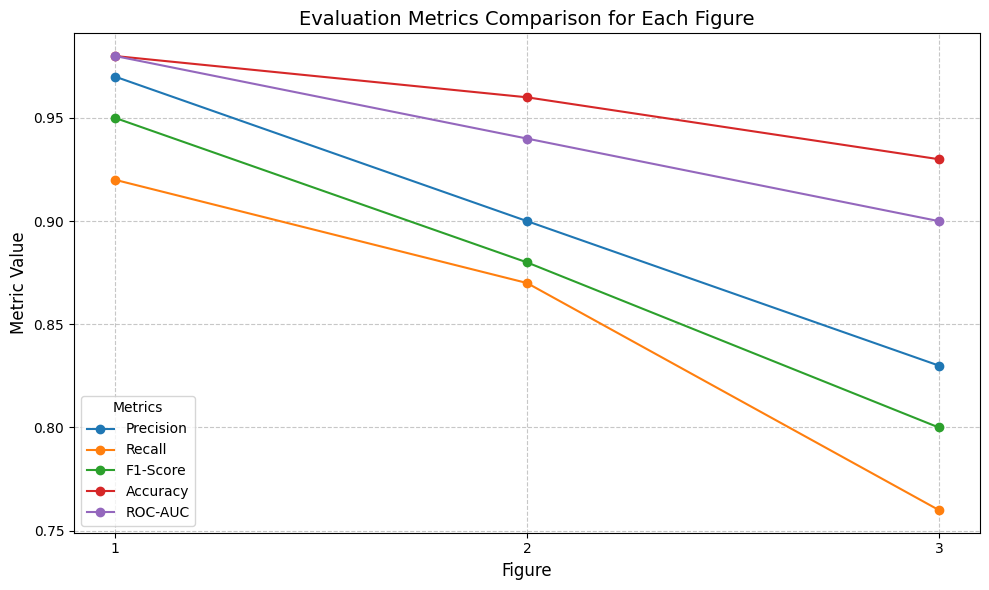

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for evaluation metrics
data = {
    "Figure": ["1", "2", "3"],
    "Precision": [0.97, 0.90, 0.83],
    "Recall": [0.92, 0.87, 0.76],
    "F1-Score": [0.95, 0.88, 0.80],
    "Accuracy": [0.98, 0.96, 0.93],
    "ROC-AUC": [0.98, 0.94, 0.90],
}

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data)

# Set figure size
plt.figure(figsize=(10, 6))

# Plot each metric
for metric in ["Precision", "Recall", "F1-Score", "Accuracy", "ROC-AUC"]:
    plt.plot(df["Figure"], df[metric], marker='o', label=metric)

# Formatting the plot
plt.title("Evaluation Metrics Comparison for Each Figure", fontsize=14)
plt.xlabel("Figure", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(df["Figure"])
plt.legend(title="Metrics", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("Evaluation_Metric_Comparison.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()


##COMPLEX IMAGE ANALYSIS

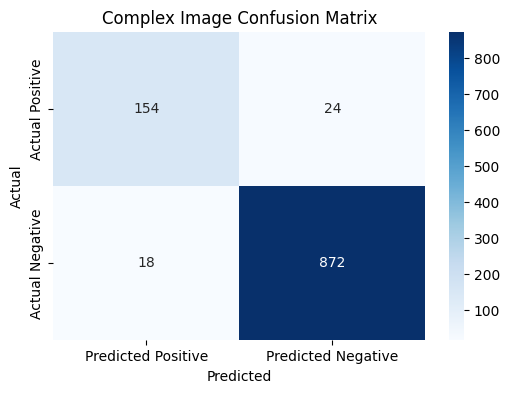

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated data for all figures (from Table 11)
table_11_data = [
    {"Figure": "11:", "Total TP": 154, "Total FP": 18, "Total TN": 872, "Total FN": 24},
]

# Convert the table data into a pandas DataFrame for easier processing
df = pd.DataFrame(table_11_data)

# Visualize and save confusion matrix for each figure
for _, row in df.iterrows():
    figure = f"Figure {row['Figure']}"
    tp = row["Total TP"]
    fp = row["Total FP"]
    tn = row["Total TN"]
    fn = row["Total FN"]

    # Complete confusion matrix
    matrix = [[tp, fn], [fp, tn]]

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Positive", "Predicted Negative"],
        yticklabels=["Actual Positive", "Actual Negative"],
    )
    plt.title(f"Complex Image Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the plot as an image
    filename = f"Complex_Image_Confusion_Matrix.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


In [12]:
from sklearn.metrics import roc_auc_score
import pandas as pd

# Updated data for all figures (from Table 11)
table_11_data = [
    {"Figure": "11", "TP": 154, "FP": 18, "TN": 872, "FN": 24},
]

# Results list to store calculated metrics
results = []

# Calculate metrics for each figure
for row in table_11_data:
    figure = f"Figure {row['Figure']}"
    tp = row["TP"]
    fp = row["FP"]
    tn = row["TN"]
    fn = row["FN"]

    # Metrics calculations
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (2 * precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    # Simplified ROC-AUC calculation
    y_true = [1] * tp + [0] * fn + [1] * fp + [0] * tn  # Actual labels
    y_scores = [1] * (tp + fp) + [0] * (tn + fn)  # Predicted scores
    roc_auc = roc_auc_score(y_true, y_scores)

    # Append results
    results.append({
        "Figure": figure,
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-Score": round(f1_score, 2),
        "Accuracy": round(accuracy, 2),
        "ROC-AUC": round(roc_auc, 2),
    })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Display the updated results
print(results_df)


      Figure  Precision  Recall  F1-Score  Accuracy  ROC-AUC
0  Figure 11        0.9    0.87      0.88      0.96     0.94


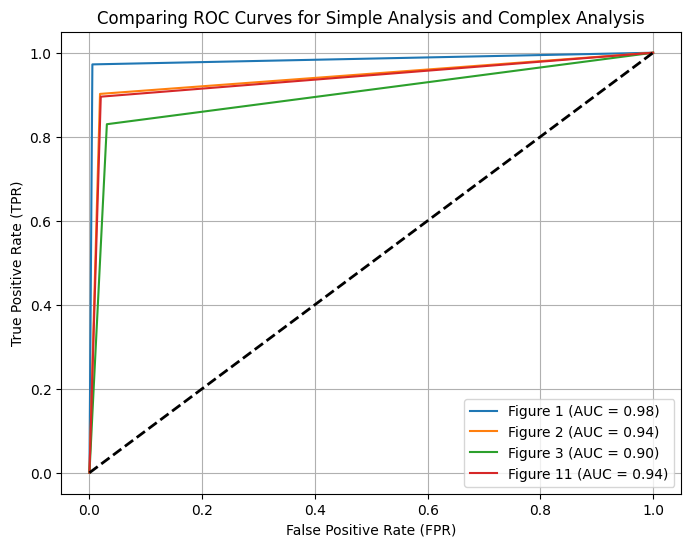

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Updated data for all figures (from Table 6)
table_6and11_data = [
    {"Figure": "1", "Total TP": 35, "Total FP": 1, "Total TN": 190, "Total FN": 3},
    {"Figure": "2", "Total TP": 46, "Total FP": 5, "Total TN": 260, "Total FN": 7},
    {"Figure": "3", "Total TP": 39, "Total FP": 8, "Total TN": 247, "Total FN": 12},
    {"Figure": "11", "Total TP": 154, "Total FP": 18, "Total TN": 872, "Total FN": 24},
]

# Generate ROC curve for each figure using simulated data
plt.figure(figsize=(8, 6))
for row in table_6and11_data:
    figure = f"Figure {row['Figure']}"
    tp = row["Total TP"]
    fp = row["Total FP"]
    tn = row["Total TN"]
    fn = row["Total FN"]

    # Simulate true labels and predicted scores
    y_true = [1] * tp + [0] * fn + [1] * fp + [0] * tn
    y_scores = [1] * (tp + fp) + [0] * (tn + fn)

    # Calculate TPR, FPR, and AUC using roc_curve and roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Plot ROC curve
    plt.plot(
        fpr, tpr, label=f"{figure} (AUC = {roc_auc:.2f})"
    )

# Plot formatting
plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line for random performance
plt.title("Comparing ROC Curves for Simple Analysis and Complex Analysis")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("Comparing_ROC_Curves.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()


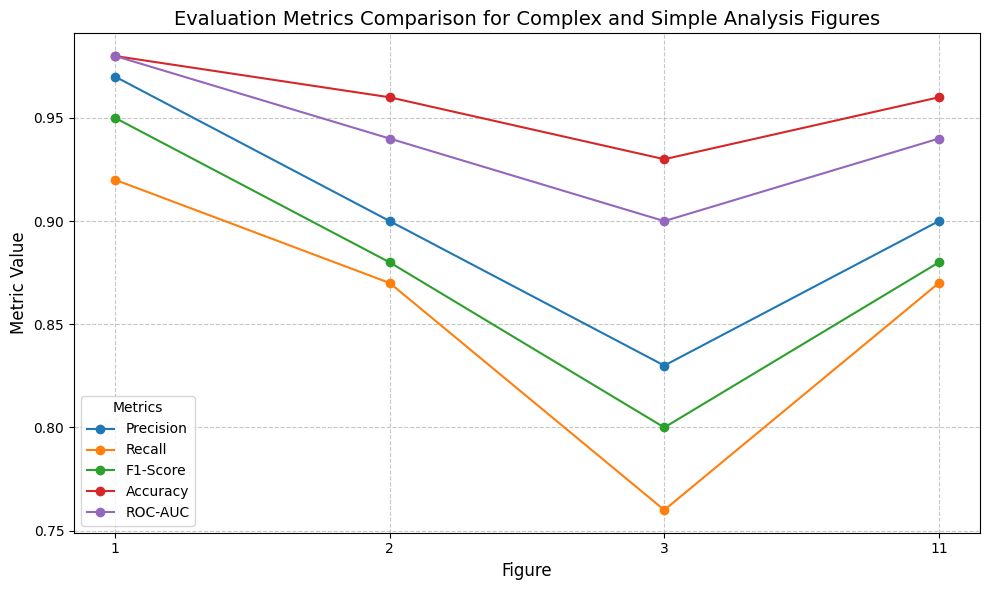

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for evaluation metrics
allData = {
    "Figure": ["1", "2", "3", "11"],
    "Precision": [0.97, 0.90, 0.83, 0.9],
    "Recall": [0.92, 0.87, 0.76, 0.87],
    "F1-Score": [0.95, 0.88, 0.80, 0.88],
    "Accuracy": [0.98, 0.96, 0.93, 0.96],
    "ROC-AUC": [0.98, 0.94, 0.90, 0.94],
}

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(allData)

# Set figure size
plt.figure(figsize=(10, 6))

# Plot each metric
for metric in ["Precision", "Recall", "F1-Score", "Accuracy", "ROC-AUC"]:
    plt.plot(df["Figure"], df[metric], marker='o', label=metric)

# Formatting the plot
plt.title("Evaluation Metrics Comparison for Complex and Simple Analysis Figures", fontsize=14)
plt.xlabel("Figure", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.xticks(df["Figure"])
plt.legend(title="Metrics", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("Evaluation_Metric_Comparison_All.png", dpi=300, bbox_inches="tight")  # Save the plot
plt.show()